In [2]:
from __future__ import print_function

%matplotlib inline

import sys
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.contrib.framework.python.ops import variables

from collections import OrderedDict

import numpy as np
import scipy.misc
from input import *
from model import *
from train import *
import matplotlib.pyplot as plt
tf.reset_default_graph()

1.3.0


In [3]:
image_shape = (160,576)
iterator, filename = get_train_inputs(batch_size=100,
                                      repeat=True, 
                                      num_classes=2, 
                                      image_shape=image_shape)
print(iterator, filename)

<tensorflow.contrib.data.python.ops.dataset_ops.Iterator object at 0x1225c2320> Tensor("training_data/input:0", shape=(?,), dtype=string)


**********


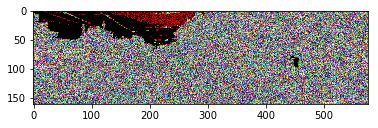

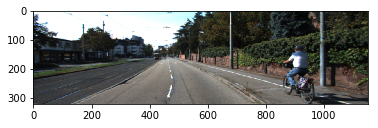

(320, 1152, 3) (160, 576, 3)
**********


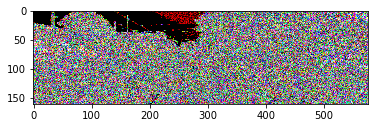

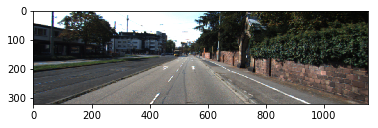

(320, 1152, 3) (160, 576, 3)
**********


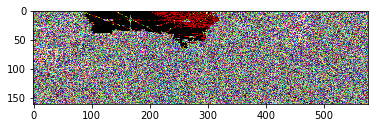

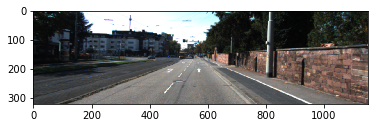

(320, 1152, 3) (160, 576, 3)
**********


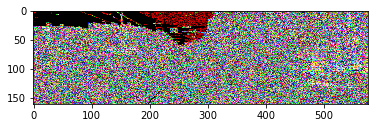

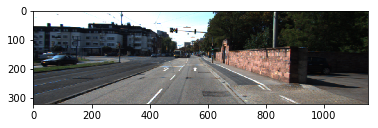

(320, 1152, 3) (160, 576, 3)


In [4]:
_show = True
if _show:
    with tf.Session() as sess:
        sess.run(iterator.initializer, feed_dict={filename: ['data/kitti_segmentation.tfrecord']})
        next_element = iterator.get_next()
        i = 1
        while i < 5:
            i += 1
            print("*"*10)
            image, label = sess.run(next_element)
            new = scipy.misc.imresize(image,(160*2,576*2) )
            plt.imshow(image[:,:,:])
            plt.show()
            plt.imshow(new[:,:,:])
#             plt.imshow(label[:,:,0], cmap='jet', alpha=0.5)
            plt.show()
            print(new.shape, image.shape)

In [4]:
label.shape

(160, 576, 2)

In [5]:
# record_iterator = tf.python_io.tf_record_iterator(path='data/kitti_segmentation.tfrecord')
# string_record = next(record_iterator)
# example = tf.train.Example()
# example.ParseFromString(string_record)

## Model

In [6]:
encoder = SlimModelEncoder(name="vgg_16", num_classes=2, is_training=True)
image, label = iterator.get_next()
assign_op, feed_dict, end_points = encoder.build(image=image, image_shape=image_shape)

In [7]:
end_points.keys()
gr = tf.get_default_graph()
gr.get_collection('table_initializer')

[]

In [8]:
print(end_points['vgg_16/conv3/conv3_3'], 
    end_points['vgg_16/conv4/conv4_3'], 
    end_points['vgg_16/conv5/conv5_3'],
    end_points['vgg_16/fc6'],
    end_points['vgg_16/fc7'],sep='\n')

Tensor("vgg_16/conv3/conv3_3/Relu:0", shape=(1, 40, 144, 256), dtype=float32)
Tensor("vgg_16/conv4/conv4_3/Relu:0", shape=(1, 20, 72, 512), dtype=float32)
Tensor("vgg_16/conv5/conv5_3/Relu:0", shape=(1, 10, 36, 512), dtype=float32)
Tensor("vgg_16/fc6/Relu:0", shape=(1, 5, 18, 4096), dtype=float32)
Tensor("vgg_16/fc7/Relu:0", shape=(1, 5, 18, 4096), dtype=float32)


In [9]:
decoder = FCNDecoder(end_points, nb_classes=2, scope='decoder')

In [10]:
tensors_to_connect = OrderedDict()
tensors_to_connect["vgg_16/fc7"] = (2,2)
tensors_to_connect['vgg_16/conv5/conv5_3'] = (2,2)
tensors_to_connect['vgg_16/conv4/conv4_3'] = (8,8)

In [11]:
net = decoder.build(tensors_to_connect)

TypeError: convolution2d_transpose() got an unexpected keyword argument 'activation'

In [ ]:
assert tuple(gr.get_tensor_by_name('logit:0').get_shape().as_list()[1:3]) == image_shape

## Train

In [ ]:
trainer = Trainer(nb_classes=2, optimizer=tf.train.AdamOptimizer, learning_rate=1e-4)

In [ ]:
trainer.build(predictions=net, labels=label, decoder_scope='decoder')

In [ ]:
trainer.train(iterator, assign_op=assign_op, feed_dict=feed_dict, filename=['data/kitti_segmentation.tfrecord'])

## Predict

In [ ]:
TRAIN_DIR = "/tmp/tf"
with tf.Graph().as_default() as graph:
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(os.path.join(TRAIN_DIR,"model.ckpt-3000.meta"))
        saver.restore(sess, os.path.join(TRAIN_DIR,"model.ckpt-3000"))
        # predictions and labels
        input_tensor = graph.get_tensor_by_name('training_data/input:0')
        logit = graph.get_tensor_by_name('logit:0')
        logit = tf.squeeze(logit)
        pred = tf.argmax(logit, axis=2)
        pred_ = sess.run(pred)

In [ ]:
tf.add_to_collection(tf.GraphKeys.TABLE_INITIALIZERS, iterator.initializer)

In [ ]:
gr.collections